In [6]:
import pandas as pd
from typing import List, Tuple
import numpy as np

from preprocess import create_min_max_df, scale_data, downsample_timeseries_data, slice_timeseries_data, masked_expand

In [7]:
# Example usage:
df = pd.read_csv(r"../data/jena_climate_2009_2016.csv",
                parse_dates=['Date Time'], 
                index_col=['Date Time'])
df.index = pd.to_datetime(df.index, format='%d.%m.%Y %H:%M:%S')
df = df.iloc[:5000,:]
context_windows = ['1H', '2H', '6H']
context_sizes = [24, 12, 6]
call_window = '10T'
call_size = 24
response_window = '10T'
response_size = 8
call_feature_index = range(0,14)
context_feature_index = [range(0,14),
                        range(0,14),
                        range(0,14)]
response_feature_index = [0, 1, 4]
thresholds = {
    'call': 0.7,
    'response': 0.7,
    'context_0': 0.7,
    'context_1': 0.7,
    'context_2': 0.7
}
sizes = {
    'call': 24,
    'response': 8,
    'context_0': 24,
    'context_1': 12,
    'context_2': 6
}

In [8]:
#Scale Data
min_max_df = create_min_max_df(df)
print(min_max_df)
scaled_df = scale_data(df, min_max_df, feature_range=(0, 1))

                     min      max
p (mbar)          944.58  1005.71
T (degC)          -23.01     7.64
Tpot (K)          250.60   283.19
Tdew (degC)       -25.01     2.51
rh (%)             42.38   100.00
VPmax (mbar)        0.95    10.48
VPact (mbar)        0.79     7.32
VPdef (mbar)        0.00     4.94
sh (g/kg)           0.50     4.80
H2OC (mmol/mol)     0.80     7.69
rho (g/m**3)     1179.43  1383.38
wv (m/s)            0.00     9.71
max. wv (m/s)       0.00    14.50
wd (deg)            0.00   358.90


In [4]:
downsampled_data = downsample_timeseries_data(scaled_df, 
                                        context_windows, 
                                        call_window, 
                                        response_window,
                                        call_feature_index,
                                        context_feature_index,
                                        response_feature_index)
downsampled_data

{'call':                      p (mbar)  T (degC)  Tpot (K)  Tdew (degC)    rh (%)  \
 2009-01-01 00:10:00  0.849665  0.489070  0.454127     0.585392  0.883721   
 2009-01-01 00:20:00  0.850483  0.476346  0.442160     0.571584  0.885456   
 2009-01-01 00:30:00  0.849828  0.473083  0.439092     0.570494  0.894134   
 2009-01-01 00:40:00  0.849501  0.479608  0.445535     0.579215  0.899341   
 2009-01-01 00:50:00  0.849501  0.480914  0.446456     0.580305  0.897605   
 ...                       ...       ...       ...          ...       ...   
 2009-02-04 16:40:00  0.435302  0.821207  0.829396     0.897892  0.717112   
 2009-02-04 16:50:00  0.435302  0.813703  0.822031     0.898256  0.743145   
 2009-02-04 17:00:00  0.435793  0.813703  0.822031     0.901163  0.751822   
 2009-02-04 17:10:00  0.438737  0.811746  0.820190     0.900073  0.753558   
 2009-02-04 17:20:00  0.442827  0.815661  0.822952     0.904070  0.753558   
 
                      VPmax (mbar)  VPact (mbar)  VPdef (mbar)  sh

In [5]:
sliced_data, selected_timestamps = slice_timeseries_data(downsampled_data,
                                    sizes,
                                    thresholds)

sliced_data

{'context_0': array([[[0.87313921, 0.4473627 , 0.41162933, ..., 0.08427738,
          0.10356322, 0.40466704],
         [0.88508097, 0.47199565, 0.43315946, ..., 0.14469619,
          0.13390805, 0.91028142],
         [0.89639566, 0.49211528, 0.45044492, ..., 0.05217988,
          0.06045977, 0.61177673],
         ...,
         [0.88276351, 0.60609027, 0.5595786 , ..., 0.06591143,
          0.07195402, 0.51109873],
         [0.87602923, 0.59624796, 0.55139613, ..., 0.07621009,
          0.08632184, 0.48611498],
         [0.87551121, 0.59510604, 0.55037333, ..., 0.07020254,
          0.08494253, 0.57341414]],
 
        [[0.87313921, 0.4473627 , 0.41162933, ..., 0.08427738,
          0.10356322, 0.40466704],
         [0.88508097, 0.47199565, 0.43315946, ..., 0.14469619,
          0.13390805, 0.91028142],
         [0.89639566, 0.49211528, 0.45044492, ..., 0.05217988,
          0.06045977, 0.61177673],
         ...,
         [0.88276351, 0.60609027, 0.5595786 , ..., 0.06591143,
          0

In [6]:
for key in sliced_data:
    print(sliced_data[key].shape)

(4816, 24, 14)
(4816, 12, 14)
(4816, 6, 14)
(4816, 24, 14)
(4816, 8, 3)


In [7]:
expanded_dict, response_data = masked_expand(sliced_data, sizes)

print(response_data[0,:])
for ir in range(30):
    print(expanded_dict['response'][ir,:,:])
    
for key in expanded_dict:
    print(expanded_dict[key].shape)
    
print(response_data.shape)

[0.87387535 0.60619902 0.93405068]
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
[[0.87387535 0.60619902 0.93405068]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[0.87387535 0.60619902 0.93405068]
 [0.87567479 0.60783034 0.92884415]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[0.87387535 0.60619902 0.93405068]
 [0.87567479 0.60783034 0.92884415]
 [0.87632913 0.60978793 0.92884415]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[

In [8]:
print(expanded_dict)

{'context_0': array([[[0.87313921, 0.4473627 , 0.41162933, ..., 0.08427738,
         0.10356322, 0.40466704],
        [0.88508097, 0.47199565, 0.43315946, ..., 0.14469619,
         0.13390805, 0.91028142],
        [0.89639566, 0.49211528, 0.45044492, ..., 0.05217988,
         0.06045977, 0.61177673],
        ...,
        [0.88276351, 0.60609027, 0.5595786 , ..., 0.06591143,
         0.07195402, 0.51109873],
        [0.87602923, 0.59624796, 0.55139613, ..., 0.07621009,
         0.08632184, 0.48611498],
        [0.87551121, 0.59510604, 0.55037333, ..., 0.07020254,
         0.08494253, 0.57341414]],

       [[0.87313921, 0.4473627 , 0.41162933, ..., 0.08427738,
         0.10356322, 0.40466704],
        [0.88508097, 0.47199565, 0.43315946, ..., 0.14469619,
         0.13390805, 0.91028142],
        [0.89639566, 0.49211528, 0.45044492, ..., 0.05217988,
         0.06045977, 0.61177673],
        ...,
        [0.88276351, 0.60609027, 0.5595786 , ..., 0.06591143,
         0.07195402, 0.51109873]

In [75]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

def ksize(size):
    return max([2, round(size / 9)])

class FormHead(nn.Module):
    def __init__(self, size, feature_len, csize=64):
        super(FormHead, self).__init__()
        self.conv = nn.Conv2d(1, csize, kernel_size=(ksize(size), ksize(feature_len)))
        self.pool = nn.MaxPool2d(2, 2)
        # Placeholder for the linear layer
        self.fc = None

    def forward(self, x):
        x = F.leaky_relu(self.conv(x))
        x = self.pool(x)
        x = torch.flatten(x, 1)
        if self.fc is None:
            # Dynamically compute the input size for the linear layer
            size = x.size(1)
            self.fc = nn.Linear(size, 64)
        x = F.leaky_relu(self.fc(x))
        return x

class Cerberus(nn.Module):
    def __init__(self, training_data, response_data, csize=64):
        super(Cerberus, self).__init__()
        train_call = training_data['call']
        train_contexts = [training_data[key] for key in training_data if 'context' in key]
        train_response = training_data['response']

        context_dims = [cont.shape for cont in train_contexts]
        call_size, call_fl = train_call.shape[1], train_call.shape[2]
        res_size, res_fl = train_response.shape[1], train_response.shape[2]

        self.call_head = FormHead(call_size, call_fl, csize)
        self.context_heads = nn.ModuleList([FormHead(icl[1], icl[2], csize) for icl in context_dims])
        self.response_head = FormHead(res_size, res_fl, csize)

        self.fc1 = nn.Linear(csize * (2 + len(context_dims)), csize * 16)
        self.fc2 = nn.Linear(csize * 16, csize * 8)
        self.fc3 = nn.Linear(csize * 8 + train_call.shape[2], csize * 4)
        self.fc4 = nn.Linear(csize * 4, csize)
        self.fc5 = nn.Linear(csize, csize // 2)
        self.out = nn.Linear(csize // 2, response_data.shape[1])

    def forward(self, x_call, x_contexts, x_response):
        call_head_out = self.call_head(x_call)
        last_known = x_call[:,0,-1,:]
        context_heads_out = [head(x) for head, x in zip(self.context_heads, x_contexts)]
        response_head_out = self.response_head(x_response)
        necks = torch.cat([call_head_out] + context_heads_out + [response_head_out], dim=1)
        # print(necks.shape)
        necks = F.leaky_relu(self.fc1(necks))
        necks = F.leaky_relu(self.fc2(necks))
        body = F.leaky_relu(self.fc3(torch.cat([necks] + [last_known], dim=1)))
        body = F.leaky_relu(self.fc4(body))
        body = F.leaky_relu(self.fc5(body))
        body = self.out(body)
        return body

In [83]:
from torch.utils.data import DataLoader, TensorDataset
import random

num_epochs = 30

model = Cerberus(expanded_dict, response_data)

# Define a loss function and optimizer
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# print([key for key in expanded_dict if 'context' in key])
# # Prepare your data
# # Assuming 'training_data' and 'response_data' are your inputs and targets
# train_dataset = TensorDataset(expanded_dict['call'], [expanded_dict[key] for key in expanded_dict if 'context' in key], expanded_dict['response'], response_data)
# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# for calls, contexts, responses, y in train_loader:
#     print(calls)

train_len = 20000
train_index = random.sample(range(train_len),train_len)
calls = torch.tensor(expanded_dict['call'][train_index,:,:], dtype=torch.float32).unsqueeze(1)
contexts = [torch.tensor(expanded_dict[key][train_index,:,:], dtype=torch.float32).unsqueeze(1) for key in expanded_dict if 'context' in key]
responses = torch.tensor(expanded_dict['response'][train_index,:,:], dtype=torch.float32).unsqueeze(1)

y = torch.tensor(response_data[train_index,:], dtype=torch.float32)
batch_size = 100
# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i in range(0, len(calls), batch_size):
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(calls[i:i+batch_size], [cont[i:i+batch_size] for cont in contexts], responses[i:i+batch_size])
        loss = criterion(outputs, y[i:i+batch_size])

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss}")


Epoch [1/30], Loss: 12.358403718928457
Epoch [2/30], Loss: 1.7593770126986783
Epoch [3/30], Loss: 1.388539621635573
Epoch [4/30], Loss: 1.1922914572642185
Epoch [5/30], Loss: 1.0717979073888273
Epoch [6/30], Loss: 0.9516110725307954
Epoch [7/30], Loss: 0.8846544335756334
Epoch [8/30], Loss: 0.7980563290402642
Epoch [9/30], Loss: 0.7336204673629254
Epoch [10/30], Loss: 0.6881559846442542
Epoch [11/30], Loss: 0.6483069041059935
Epoch [12/30], Loss: 0.6101470043322479
Epoch [13/30], Loss: 0.5801451229963277
Epoch [14/30], Loss: 0.5563584386945877
Epoch [15/30], Loss: 0.5223385033095838
Epoch [16/30], Loss: 0.503499961378111
Epoch [17/30], Loss: 0.4885208772138867
Epoch [18/30], Loss: 0.4676636435033288
Epoch [19/30], Loss: 0.4427326031582197
Epoch [20/30], Loss: 0.44979617211356526
Epoch [21/30], Loss: 0.4335558220773237
Epoch [22/30], Loss: 0.40433245395252015
Epoch [23/30], Loss: 0.40452255150012206
Epoch [24/30], Loss: 0.3952209118506289
Epoch [25/30], Loss: 0.38028330038287095
Epoch [

In [84]:
# 3. Set the model to evaluation mode
model.eval()

# 4. Run the model forward pass
with torch.no_grad():  # No need to compute gradients during inference
    predictions = model(calls, contexts, responses)
predictions = predictions.numpy()

print(predictions)

[[0.9702549  0.33798715 0.8426923 ]
 [0.9572127  0.5938287  0.80071175]
 [0.4540997  0.85542846 0.64549685]
 ...
 [0.81309783 0.76653135 0.8527554 ]
 [0.69636256 0.72188514 0.78657633]
 [0.93084323 0.38948393 0.7982193 ]]


In [85]:
# 3. Set the model to evaluation mode
model.eval()

# 4. Run the model forward pass
with torch.no_grad():  # No need to compute gradients during inference
    predictions = model(calls, contexts, responses)
predictions = predictions.numpy()
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(predictions)
plt.plot(y.numpy())


KeyboardInterrupt: 

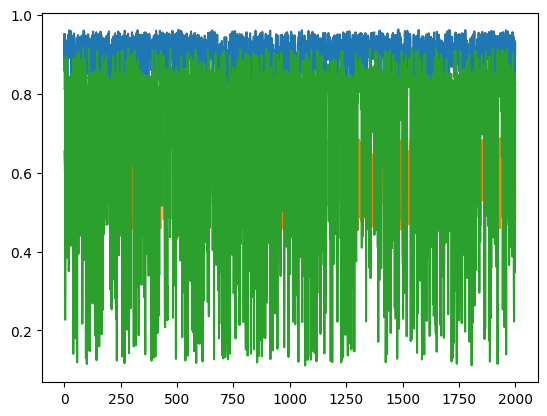

In [79]:
plt.plot(predictions)

In [86]:
def generate_predictions(model,selected_data):
    calls = torch.tensor(selected_data['call'], dtype=torch.float32).unsqueeze(1)
    contexts = [torch.tensor(selected_data[key], dtype=torch.float32).unsqueeze(1) for key in selected_data if 'context' in key]
    responses = torch.tensor(np.zeros([1,selected_data['response'].shape[1],selected_data['response'].shape[2]]), dtype=torch.float32).unsqueeze(1)
    
    respones_generated = []
    for igen in range(responses.shape[2]):
        with torch.no_grad():
            res_out = model(calls, contexts, responses)
            responses[0,0,igen,:] = res_out[0]
            print(responses)
            respones_generated.append(res_out[0].numpy())
        
    return np.vstack(respones_generated)

In [89]:
selected_data = {key: value[500:501,:] for key, value in sliced_data.items()}
responses_generated = generate_predictions(model,selected_data)
print(selected_data['response'])
print(responses_generated)

tensor([[[[0.8214, 0.5372, 0.7910],
          [0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000]]]])
tensor([[[[0.8214, 0.5372, 0.7910],
          [0.8197, 0.5345, 0.7824],
          [0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000]]]])
tensor([[[[0.8214, 0.5372, 0.7910],
          [0.8197, 0.5345, 0.7824],
          [0.8197, 0.5295, 0.7815],
          [0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000]]]])
tensor([[[[0.8214, 0.5372, 0.7910],
          [0.8197, 0.5345, 0.7824],
          [0.8197, 0.5295, 0.7815],
          [0.8162, 

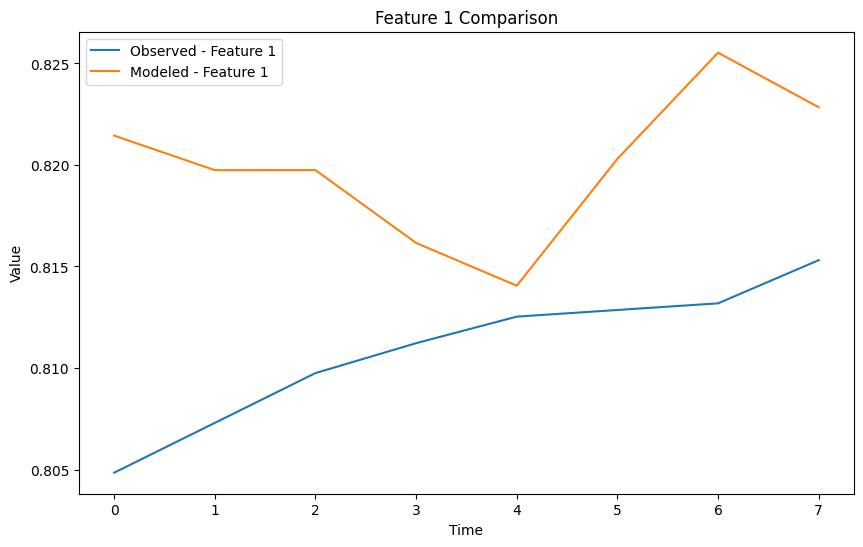

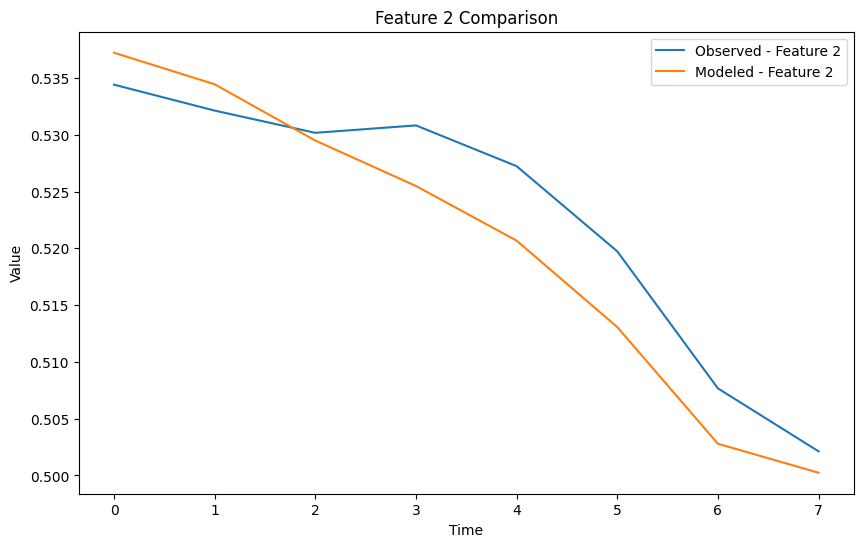

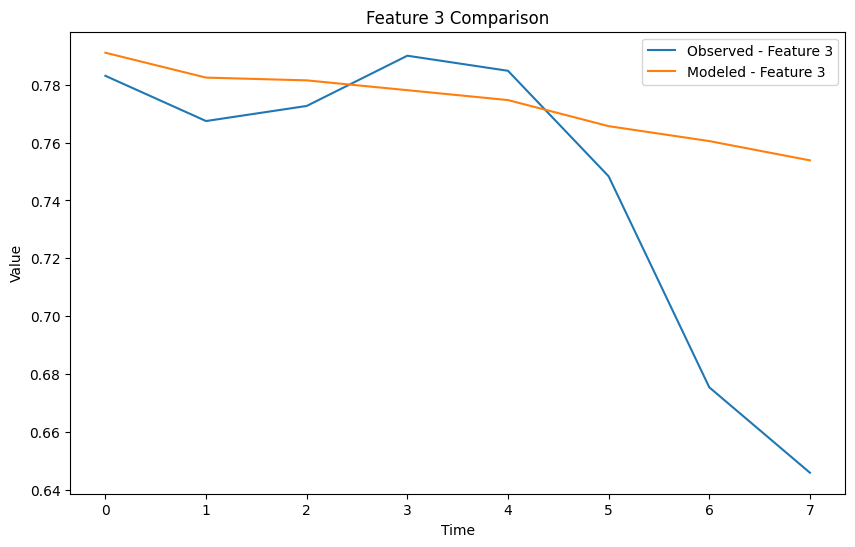

In [90]:
import matplotlib.pyplot as plt
import numpy as np

# Example matrices
observed = selected_data['response'][0,:,:]
modeled = responses_generated

# Number of rows and columns
num_rows, num_cols = observed.shape

# Create a plot for each feature (column)
for i in range(num_cols):
    plt.figure(figsize=(10, 6))
    plt.plot(observed[:, i], label='Observed - Feature {}'.format(i+1))
    plt.plot(modeled[:, i], label='Modeled - Feature {}'.format(i+1))
    plt.title(f'Feature {i+1} Comparison')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.show()
